In [1]:
import pandas as pd
import pandas_datareader.data as web
import pandas_datareader.famafrench as ff
import datetime
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import LSTM, Dense, Reshape
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [2]:
np.set_printoptions(linewidth=160)
pd.set_option('display.max_columns', None)

In [3]:
start = datetime.datetime(1998, 1, 1)
end = datetime.datetime(2021, 1, 1)

tickers = pd.read_csv("DJIA.csv", header=None) # components as of 2021-03-09
tickers = list(tickers[0])
for ticker in tickers:
    print(ticker)

MMM
AXP
AMGN
AAPL
BA
CAT
CVX
CSCO
KO
DOW
GS
HD
HON
IBM
INTC
JNJ
JPM
MCD
MRK
MSFT
NKE
PG
CRM
TRV
UNH
VZ
V
WBA
WMT
DIS


In [4]:
ff.get_available_datasets()

['F-F_Research_Data_Factors',
 'F-F_Research_Data_Factors_weekly',
 'F-F_Research_Data_Factors_daily',
 'F-F_Research_Data_5_Factors_2x3',
 'F-F_Research_Data_5_Factors_2x3_daily',
 'Portfolios_Formed_on_ME',
 'Portfolios_Formed_on_ME_Wout_Div',
 'Portfolios_Formed_on_ME_Daily',
 'Portfolios_Formed_on_BE-ME',
 'Portfolios_Formed_on_BE-ME_Wout_Div',
 'Portfolios_Formed_on_BE-ME_Daily',
 'Portfolios_Formed_on_OP',
 'Portfolios_Formed_on_OP_Wout_Div',
 'Portfolios_Formed_on_OP_Daily',
 'Portfolios_Formed_on_INV',
 'Portfolios_Formed_on_INV_Wout_Div',
 'Portfolios_Formed_on_INV_Daily',
 '6_Portfolios_2x3',
 '6_Portfolios_2x3_Wout_Div',
 '6_Portfolios_2x3_weekly',
 '6_Portfolios_2x3_daily',
 '25_Portfolios_5x5',
 '25_Portfolios_5x5_Wout_Div',
 '25_Portfolios_5x5_Daily',
 '100_Portfolios_10x10',
 '100_Portfolios_10x10_Wout_Div',
 '100_Portfolios_10x10_Daily',
 '6_Portfolios_ME_OP_2x3',
 '6_Portfolios_ME_OP_2x3_Wout_Div',
 '6_Portfolios_ME_OP_2x3_daily',
 '25_Portfolios_ME_OP_5x5',
 '25_Portf

In [5]:
ff_dict = web.DataReader('North_America_5_Factors_Daily', "famafrench", start, end)
print(ff_dict.pop("DESCR"))
ff_dict = ff_dict[0]

North America 5 Factors Daily
-----------------------------

This file was created using the 202012 Bloomberg database. Missing data are indicated by -99.99. 

  0 : (6001 rows x 6 cols)


In [6]:
factors = pd.DataFrame(ff_dict)
factors.index = pd.to_datetime(factors.index.to_timestamp())
factors

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
1998-01-01,-0.02,0.00,0.00,0.00,0.00,0.02
1998-01-02,0.23,-0.08,-0.54,0.15,-0.19,0.02
1998-01-05,0.24,-0.03,-0.39,0.11,0.01,0.02
1998-01-06,-1.09,0.25,0.01,-0.21,0.09,0.02
1998-01-07,-0.37,-0.27,-0.19,0.22,0.35,0.02
...,...,...,...,...,...,...
2020-12-25,0.00,0.00,0.00,0.00,0.00,0.00
2020-12-28,0.50,-0.86,0.34,1.05,0.39,0.00
2020-12-29,-0.36,-1.17,0.29,0.54,0.12,0.00


In [7]:
mom_dict = web.DataReader('North_America_MOM_Factor_Daily', "famafrench", start, end)
print(mom_dict.pop("DESCR"))
mom_dict = mom_dict[0]
mom_factors = pd.DataFrame(mom_dict)
mom_factors.index = pd.to_datetime(mom_factors.index.to_timestamp())
mom_factors

North America MOM Factor Daily
------------------------------

This file was created using the 202012 Bloomberg database. Missing data are indicated by -99.99. 

  0 : (6001 rows x 1 cols)


,WML
Date,
1998-01-01,0.00
1998-01-02,-1.16
1998-01-05,0.14
1998-01-06,0.07
1998-01-07,-0.45
...,...
2020-12-25,0.00
2020-12-28,-0.76
2020-12-29,-0.41


In [8]:
COMPUSTAT = pd.read_csv("p9o3mgqulrwmikax.csv")
COMPUSTAT.dropna(thresh=COMPUSTAT.shape[0]*0.99,how='all',axis=1, inplace=True) # REMOVE FEATURE IF NaN > 10%
COMPUSTAT=COMPUSTAT[COMPUSTAT.isna().sum().sort_values().keys()]
COMPUSTAT.set_index(pd.to_datetime(COMPUSTAT["public_date"], format="%Y%m%d"), inplace=True) # TODO IS THIS CORRECT?
COMPUSTAT = COMPUSTAT.drop(columns = ["gvkey", "permno", "qdate", "adate", "public_date", "cusip"])
COMPUSTAT[COMPUSTAT["TICKER"]=="MMM"]

,rd_sale,sale_invcap,GProf,ptpm,gpm,opmad,equity_invcap,npm,ps,opmbd,staff_sale,adv_sale,TICKER,de_ratio,debt_assets,cash_lt,aftret_eq,aftret_equity,at_turn,roa,pcf,accrual,debt_capital,bm,ptb,sale_equity,debt_at,totdebt_invcap,debt_invcap,capital_ratio,lt_debt,pe_inc,cash_debt,roe
public_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1970-01-31,0.000,1.592,0.604,0.231,0.500,0.230,0.977,0.112,3.398,0.269,0.279,0.000,MMM,0.338,0.251,0.364,0.197,0.197,1.279,0.344,31.044,0.014,NaN,0.152,6.346,1.629,0.030,0.040,0.013,0.013,0.040,31.564,0.604,0.197
1970-02-28,0.048,1.594,0.601,0.227,0.501,0.220,0.972,0.111,3.686,0.260,0.281,0.000,MMM,0.360,0.263,0.292,0.194,0.194,1.287,0.334,37.377,-0.016,0.121,0.160,6.042,1.639,0.047,0.063,0.022,0.022,0.063,33.956,0.449,0.194
1970-03-31,0.048,1.594,0.601,0.227,0.501,0.220,0.972,0.111,3.534,0.260,0.281,0.000,MMM,0.360,0.263,0.292,0.194,0.194,1.287,0.334,35.834,-0.016,0.121,0.160,5.793,1.639,0.047,0.063,0.022,0.022,0.063,32.555,0.449,0.194
1970-04-30,0.048,1.594,0.601,0.227,0.501,0.220,0.972,0.111,3.171,0.260,0.281,0.000,MMM,0.360,0.263,0.292,0.194,0.194,1.287,0.334,32.148,-0.016,0.121,0.160,5.197,1.639,0.047,0.063,0.022,0.022,0.063,29.206,0.449,0.194
1970-05-31,0.000,1.631,0.601,0.223,0.501,0.220,0.978,0.111,2.808,0.260,0.281,0.000,MMM,0.360,0.263,0.292,0.185,0.185,1.287,0.334,28.976,-0.016,0.121,0.160,4.684,1.668,0.047,0.063,0.022,0.022,0.063,25.920,0.449,0.041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,0.061,1.061,0.379,0.203,0.539,0.214,0.353,0.164,2.995,0.270,0.000,0.011,MMM,3.268,0.765,0.144,0.501,0.501,0.703,0.197,12.557,0.054,0.695,0.121,8.649,3.003,0.485,0.733,0.644,0.646,0.558,18.483,0.205,0.497
2020-09-30,0.061,1.061,0.379,0.203,0.539,0.214,0.353,0.164,2.943,0.270,0.000,0.011,MMM,3.268,0.765,0.144,0.501,0.501,0.703,0.197,12.338,0.054,0.695,0.121,8.498,3.003,0.485,0.733,0.644,0.646,0.558,18.161,0.205,0.497
2020-10-31,0.061,1.061,0.379,0.203,0.539,0.214,0.353,0.164,2.943,0.270,0.000,0.011,MMM,3.268,0.765,0.144,0.501,0.501,0.703,0.197,12.339,0.054,0.695,0.121,8.499,3.003,0.485,0.733,0.644,0.646,0.558,18.136,0.205,0.497


In [9]:
DJIA_raw = web.DataReader(tickers[:1], 'yahoo', start, end) # ticker input must be a list!
DJIA_raw

Attributes,Adj Close,Close,High,Low,Open,Volume
Symbols,MMM,MMM,MMM,MMM,MMM,MMM
Date,,,,,,
1998-01-02,23.195230,41.750000,41.812500,40.875000,41.093750,2573000.0
1998-01-05,23.160500,41.687500,42.625000,41.343750,41.500000,2505600.0
1998-01-06,23.229958,41.812500,42.875000,41.500000,41.625000,3620200.0
1998-01-07,23.420925,42.156250,42.312500,41.375000,41.906250,2494800.0
1998-01-08,23.143145,41.656250,42.000000,41.125000,42.000000,1951400.0
...,...,...,...,...,...,...
2020-12-24,173.093628,174.520004,174.789993,173.419998,174.419998,656200.0
2020-12-28,173.282074,174.710007,176.399994,174.389999,175.309998,1403000.0


In [10]:
# Select features
DJIA = DJIA_raw.copy()
DJIA = DJIA[["Adj Close", "Volume"]]

In [11]:
# Convert into returns
DJIA["Adj Close"] = DJIA["Adj Close"]/DJIA["Adj Close"].shift(1)
DJIA["Adj Close"] = DJIA["Adj Close"] - 1

In [12]:
# Scale volume so that first volume for that stock is 1
for column in DJIA["Volume"]:
    DJIA["Volume", column] = DJIA["Volume", column] / DJIA["Volume", column].loc[DJIA["Volume", column].first_valid_index()]

In [13]:
# Convert to rolling average
DJIA["Volume"] = DJIA["Volume"].rolling(7).sum()

In [14]:
# Shift to get rid of NaN
DJIA = DJIA.iloc[6:]

In [15]:
DJIA["MEAN"] = DJIA["Adj Close"].mean(axis=1)
DJIA

Attributes,Adj Close,Volume,MEAN
Symbols,MMM,MMM,
Date,,,
1998-01-12,0.002269,9.197590,0.002269
1998-01-13,0.015850,8.834979,0.015850
1998-01-14,-0.000744,8.566498,-0.000744
1998-01-15,-0.018587,7.668636,-0.018587
1998-01-16,0.009091,7.681150,0.009091
...,...,...,...
2020-12-24,0.003046,5.621570,0.003046
2020-12-28,0.001089,5.409017,0.001089


In [16]:
# Converting factors to multiindex for joining later
factors = pd.concat([factors], keys=['MACRO'], axis=1)
mom_factors = pd.concat([mom_factors], keys=['MACRO'], axis=1)

In [17]:
# Putting the ticker as the first level instead of feature since we want to be able to select stocks 
DJIA.columns = DJIA.columns.swaplevel(0, 1)
DJIA

Symbols          MMM                    
Attributes Adj Close    Volume      MEAN
Date                                    
1998-01-12  0.002269  9.197590  0.002269
1998-01-13  0.015850  8.834979  0.015850
1998-01-14 -0.000744  8.566498 -0.000744
1998-01-15 -0.018587  7.668636 -0.018587
1998-01-16  0.009091  7.681150  0.009091
...              ...       ...       ...
2020-12-24  0.003046  5.621570  0.003046
2020-12-28  0.001089  5.409017  0.001089
2020-12-29 -0.004922  4.978041 -0.004922
2020-12-30  0.001495  3.709911  0.001495
2020-12-31  0.003906  3.763039  0.003906

[5782 rows x 3 columns]

In [18]:
# Merge stocks with factors
#DJIA.columns = DJIA.columns.get_level_values(0)
DJIA = DJIA.join(factors)
DJIA = DJIA.join(mom_factors)
DJIA

Symbols          MMM                      MACRO                                \
Attributes Adj Close    Volume      MEAN Mkt-RF   SMB   HML   RMW   CMA    RF   
Date                                                                            
1998-01-12  0.002269  9.197590  0.002269   0.69 -1.69 -0.32  0.85  0.61  0.02   
1998-01-13  0.015850  8.834979  0.015850   1.47  0.07 -0.62 -0.50 -0.99  0.02   
1998-01-14 -0.000744  8.566498 -0.000744   0.61  0.03  0.28 -0.05 -0.03  0.02   
1998-01-15 -0.018587  7.668636 -0.018587  -0.61  0.61  0.08 -0.13 -0.11  0.02   
1998-01-16  0.009091  7.681150  0.009091   1.09 -0.14 -0.18  0.02 -0.30  0.02   
...              ...       ...       ...    ...   ...   ...   ...   ...   ...   
2020-12-24  0.003046  5.621570  0.003046   0.24 -0.41 -0.33  0.24  0.09  0.00   
2020-12-28  0.001089  5.409017  0.001089   0.50 -0.86  0.34  1.05  0.39  0.00   
2020-12-29 -0.004922  4.978041 -0.004922  -0.36 -1.17  0.29  0.54  0.12  0.00   
2020-12-30  0.001495  3.709911  0.001495   0.30  1.00  0.37 -0.49  0.22  0.00   
2020-12-31  0.003906  3.763039  0.003906   0.39 -0.72  0.44  0.12  0.18  0.00   

Symbols           
Attributes   WML  
Date              
1998-01-12  0.22  
1998-01-13 -0.09  
1998-01-14  0.48  
1998-01-15 -0.10  
1998-01-16  0.04  
...          ...  
2020-12-24  0.10  
2020-12-28 -0.76  
2020-12-29 -0.41  
2020-12-30 -0.01  
2020-12-31 -0.82  

[5782 rows x 10 columns]

In [19]:
DJIA.replace(-99.99, np.nan, inplace=True) # For FF
print(DJIA.isna().sum())
DJIA.fillna(0, inplace=True)
print(DJIA.isna().sum())
DJIA

Symbols  Attributes
MMM      Adj Close     0
         Volume        0
         MEAN          0
MACRO    Mkt-RF        0
         SMB           0
         HML           0
         RMW           0
         CMA           0
         RF            0
         WML           0
dtype: int64
Symbols  Attributes
MMM      Adj Close     0
         Volume        0
         MEAN          0
MACRO    Mkt-RF        0
         SMB           0
         HML           0
         RMW           0
         CMA           0
         RF            0
         WML           0
dtype: int64


Symbols          MMM                      MACRO                                \
Attributes Adj Close    Volume      MEAN Mkt-RF   SMB   HML   RMW   CMA    RF   
Date                                                                            
1998-01-12  0.002269  9.197590  0.002269   0.69 -1.69 -0.32  0.85  0.61  0.02   
1998-01-13  0.015850  8.834979  0.015850   1.47  0.07 -0.62 -0.50 -0.99  0.02   
1998-01-14 -0.000744  8.566498 -0.000744   0.61  0.03  0.28 -0.05 -0.03  0.02   
1998-01-15 -0.018587  7.668636 -0.018587  -0.61  0.61  0.08 -0.13 -0.11  0.02   
1998-01-16  0.009091  7.681150  0.009091   1.09 -0.14 -0.18  0.02 -0.30  0.02   
...              ...       ...       ...    ...   ...   ...   ...   ...   ...   
2020-12-24  0.003046  5.621570  0.003046   0.24 -0.41 -0.33  0.24  0.09  0.00   
2020-12-28  0.001089  5.409017  0.001089   0.50 -0.86  0.34  1.05  0.39  0.00   
2020-12-29 -0.004922  4.978041 -0.004922  -0.36 -1.17  0.29  0.54  0.12  0.00   
2020-12-30  0.001495  3.709911  0.001495   0.30  1.00  0.37 -0.49  0.22  0.00   
2020-12-31  0.003906  3.763039  0.003906   0.39 -0.72  0.44  0.12  0.18  0.00   

Symbols           
Attributes   WML  
Date              
1998-01-12  0.22  
1998-01-13 -0.09  
1998-01-14  0.48  
1998-01-15 -0.10  
1998-01-16  0.04  
...          ...  
2020-12-24  0.10  
2020-12-28 -0.76  
2020-12-29 -0.41  
2020-12-30 -0.01  
2020-12-31 -0.82  

[5782 rows x 10 columns]

In [20]:
stocks = []
for ticker in tickers[:1]:
    stock = DJIA[[ticker, "MACRO"]]
    stock.columns = stock.columns.get_level_values(-1)
    stock = stock.join(COMPUSTAT[COMPUSTAT["TICKER"]==ticker]).fillna(method='ffill')
    stock = stock.drop(columns=["TICKER"])
    stock = stock.fillna(0)
    stocks.append(stock.iloc[60:]) # the first tend to be NaN

In [21]:
stocks[0].isna().sum()

Adj Close         0
Volume            0
Mkt-RF            0
SMB               0
HML               0
RMW               0
CMA               0
RF                0
WML               0
rd_sale           0
sale_invcap       0
GProf             0
ptpm              0
gpm               0
opmad             0
equity_invcap     0
npm               0
ps                0
opmbd             0
staff_sale        0
adv_sale          0
de_ratio          0
debt_assets       0
cash_lt           0
aftret_eq         0
aftret_equity     0
at_turn           0
roa               0
pcf               0
accrual           0
debt_capital      0
bm                0
ptb               0
sale_equity       0
debt_at           0
totdebt_invcap    0
debt_invcap       0
capital_ratio     0
lt_debt           0
pe_inc            0
cash_debt         0
roe               0
dtype: int64

In [22]:
stocks[0]

,Adj Close,Volume,Mkt-RF,SMB,HML,RMW,CMA,RF,WML,rd_sale,sale_invcap,GProf,ptpm,gpm,opmad,equity_invcap,npm,ps,opmbd,staff_sale,adv_sale,de_ratio,debt_assets,cash_lt,aftret_eq,aftret_equity,at_turn,roa,pcf,accrual,debt_capital,bm,ptb,sale_equity,debt_at,totdebt_invcap,debt_invcap,capital_ratio,lt_debt,pe_inc,cash_debt,roe
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1998-04-08,0.001351,5.832103,-0.47,0.66,-0.17,-0.46,-0.17,0.02,0.15,0.066,2.064,0.556,0.228,0.488,0.178,0.812,0.141,2.440,0.235,0.0,0.031,1.173,0.525,0.069,0.347,0.347,1.133,0.267,21.552,-0.031,0.365,0.181,6.113,2.543,0.190,0.344,0.139,0.146,0.146,17.984,0.245,0.342
1998-04-09,0.015519,5.348232,0.79,0.18,-0.07,-0.07,-0.09,0.02,0.19,0.066,2.064,0.556,0.228,0.488,0.178,0.812,0.141,2.440,0.235,0.0,0.031,1.173,0.525,0.069,0.347,0.347,1.133,0.267,21.552,-0.031,0.365,0.181,6.113,2.543,0.190,0.344,0.139,0.146,0.146,17.984,0.245,0.342
1998-04-13,0.007310,5.021687,-0.05,-0.14,0.82,-0.02,-0.13,0.02,0.15,0.066,2.064,0.556,0.228,0.488,0.178,0.812,0.141,2.440,0.235,0.0,0.031,1.173,0.525,0.069,0.347,0.347,1.133,0.267,21.552,-0.031,0.365,0.181,6.113,2.543,0.190,0.344,0.139,0.146,0.146,17.984,0.245,0.342
1998-04-14,-0.007916,4.817256,0.71,0.11,0.28,-0.43,-0.25,0.02,0.36,0.066,2.064,0.556,0.228,0.488,0.178,0.812,0.141,2.440,0.235,0.0,0.031,1.173,0.525,0.069,0.347,0.347,1.133,0.267,21.552,-0.031,0.365,0.181,6.113,2.543,0.190,0.344,0.139,0.146,0.146,17.984,0.245,0.342
1998-04-15,0.031249,5.143646,0.40,0.10,-0.11,-0.34,-0.29,0.02,-0.22,0.066,2.064,0.556,0.228,0.488,0.178,0.812,0.141,2.440,0.235,0.0,0.031,1.173,0.525,0.069,0.347,0.347,1.133,0.267,21.552,-0.031,0.365,0.181,6.113,2.543,0.190,0.344,0.139,0.146,0.146,17.984,0.245,0.342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,0.003046,5.621570,0.24,-0.41,-0.33,0.24,0.09,0.00,0.10,0.061,1.055,0.381,0.196,0.544,0.212,0.357,0.157,3.142,0.271,0.0,0.011,3.217,0.762,0.119,0.475,0.475,0.700,0.192,12.555,0.066,0.689,0.129,8.387,2.954,0.478,0.721,0.641,0.642,0.557,20.250,0.205,0.472
2020-12-28,0.001089,5.409017,0.50,-0.86,0.34,1.05,0.39,0.00,-0.76,0.061,1.055,0.381,0.196,0.544,0.212,0.357,0.157,3.142,0.271,0.0,0.011,3.217,0.762,0.119,0.475,0.475,0.700,0.192,12.555,0.066,0.689,0.129,8.387,2.954,0.478,0.721,0.641,0.642,0.557,20.250,0.205,0.472
2020-12-29,-0.004922,4.978041,-0.36,-1.17,0.29,0.54,0.12,0.00,-0.41,0.061,1.055,0.381,0.196,0.544,0.212,0.357,0.157,3.142,0.271,0.0,0.011,3.217,0.762,0.119,0.475,0.475,0.700,0.192,12.555,0.066,0.689,0.129,8.387,2.954,0.478,0.721,0.641,0.642,0.557,20.250,0.205,0.472


In [23]:
# TODO JOIN ALL STOCKS!

for stock in stocks:
    data = stock.to_numpy()
    X = []
    Y = []
    input_period = 100
    output_period = 21
    for i in range(input_period, data.shape[0]-output_period+1):
        X.append(data[(i-input_period):i, 1:])
        Y.append(data[i:(i+output_period), :1]) # we predict Adj close (return) next period

    X = np.array(X).astype('float32')
    Y = np.array(Y).astype('float32')
    print(X.shape)
    print(Y.shape)
    split = 5000
    trainX, trainY = X[:split, :], Y[:split, :]
    valX, valY = X[split+output_period:, :], Y[split+output_period:, :] # + output_period so that they dont overlap
    print(trainX.shape, trainY.shape)
    print(valX.shape, valY.shape)

(5602, 100, 41)
(5602, 21, 1)
(5000, 100, 41) (5000, 21, 1)
(581, 100, 41) (581, 21, 1)


In [24]:
print(trainX.shape, trainY.shape)
print(valX.shape, valY.shape)

(5000, 100, 41) (5000, 21, 1)
(581, 100, 41) (581, 21, 1)


In [25]:
trainX.shape

(5000, 100, 41)

Epoch 1/25
157/157 [==============================] - 23s 148ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 2/25
157/157 [==============================] - 23s 149ms/step - loss: 3.9870e-04 - mse: 3.9870e-04 - val_loss: 9.3250e-04 - val_mse: 9.3250e-04
Epoch 3/25
157/157 [==============================] - 24s 152ms/step - loss: 3.1031e-04 - mse: 3.1031e-04 - val_loss: 7.6962e-04 - val_mse: 7.6962e-04
Epoch 4/25
157/157 [==============================] - 28s 176ms/step - loss: 2.8481e-04 - mse: 2.8481e-04 - val_loss: 6.9308e-04 - val_mse: 6.9308e-04
Epoch 5/25
157/157 [==============================] - 23s 144ms/step - loss: 2.7172e-04 - mse: 2.7172e-04 - val_loss: 6.0449e-04 - val_mse: 6.0449e-04
Epoch 6/25
157/157 [==============================] - 22s 138ms/step - loss: 2.6126e-04 - mse: 2.6126e-04 - val_loss: 5.8830e-04 - val_mse: 5.8830e-04
Epoch 7/25
157/157 [==============================] - 22s 141ms/step - loss: 2.5594e-04 - mse: 2.5594e-04 - va

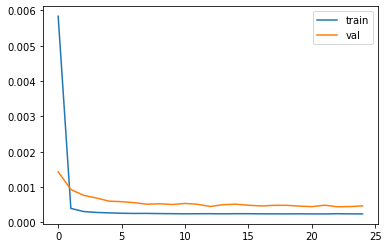

In [26]:
time_steps = trainX.shape[1]
features = trainX.shape[2]
pred_steps = output_period
pred_feat = 1

lstm_model = Sequential()

lstm_model.add(LSTM(100, return_sequences=False, input_shape=(time_steps, features)))
lstm_model.add(Dense(pred_steps*pred_feat))
lstm_model.add(Reshape([pred_steps, pred_feat]))

lstm_model.compile(loss="mse", optimizer="adam", metrics=["mse"]) # mae vs mse?

history = lstm_model.fit(trainX, trainY, epochs=25, validation_data=(valX, valY))

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [27]:
def to_cumu(y):
    y[0] += 1
    for i in range(1, len(y)):
        y[i] = (y[i]+1) * y[i-1]
    for i in range(len(y)):
        y[i] -= 1
    return y
to_cumu([0.1, 0.1, -0.1]) # good

[0.10000000000000009, 0.2100000000000002, 0.08900000000000019]

In [28]:
def to_cumu_np(array):
    array = array.copy()
    c = []
    for a in array:
        c.append(to_cumu(a)[-1])
    return c

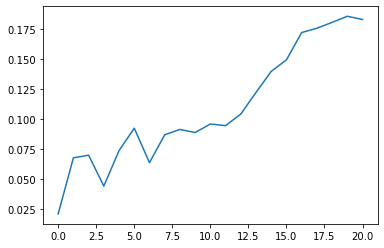

In [29]:
pred_val = lstm_model.predict(valX)
c = []
for i in range(output_period):
    c.append(np.corrcoef(to_cumu_np(pred_val[:, :i+1, 0]), to_cumu_np(valY[:, :i+1, 0]))[0][1])
plt.plot(c)

In [30]:
len(c)

21

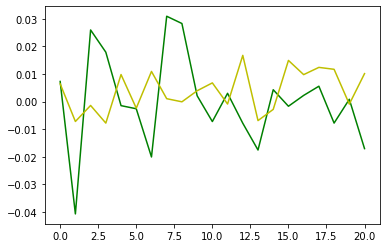

In [31]:
plt.plot(valY[300, : , 0], c="g")
plt.plot(pred_val[300, : , 0], c="y")

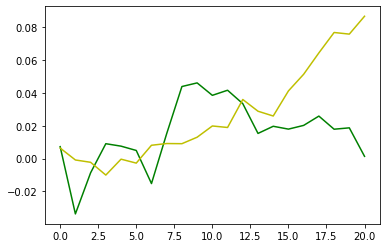

In [32]:
idx = 300
a = []
b = []
for i in range(output_period):
    a.append(to_cumu_np(valY[idx:idx+1, :i+1 , 0]))
    b.append(to_cumu_np(pred_val[idx:idx+1, :i+1 , 0]))
plt.plot(a, c="g")
plt.plot(b, c="y")

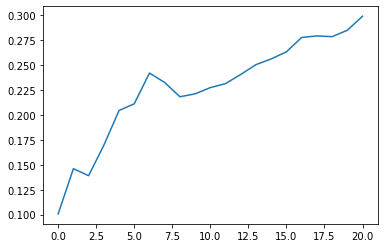

In [33]:
pred_train = lstm_model.predict(trainX)
ct = []
for i in range(output_period):
    ct.append(np.corrcoef(to_cumu_np(pred_train[:, :i+1, 0]), to_cumu_np(trainY[:, :i+1, 0]))[0][1])
plt.plot(ct)

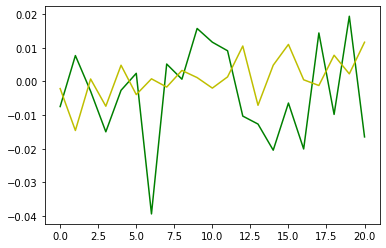

In [34]:
plt.plot(trainY[1000, : , 0], c="g")
plt.plot(pred_train[1000, : , 0], c="y")

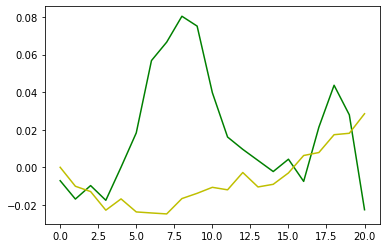

In [35]:
idx = 300
a = []
b = []
for i in range(output_period):
    a.append(to_cumu_np(trainY[idx:idx+1, :i+1 , 0]))
    b.append(to_cumu_np(pred_train[idx:idx+1, :i+1 , 0]))
plt.plot(a, c="g")
plt.plot(b, c="y")